In [16]:
import pandas as pd
import numpy as np

In [17]:
data=pd.read_csv('webtraffic.csv')

In [18]:
data.shape

(4896, 2)

In [19]:
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [20]:
import matplotlib.pyplot as plt
sessions = data['Sessions'].values

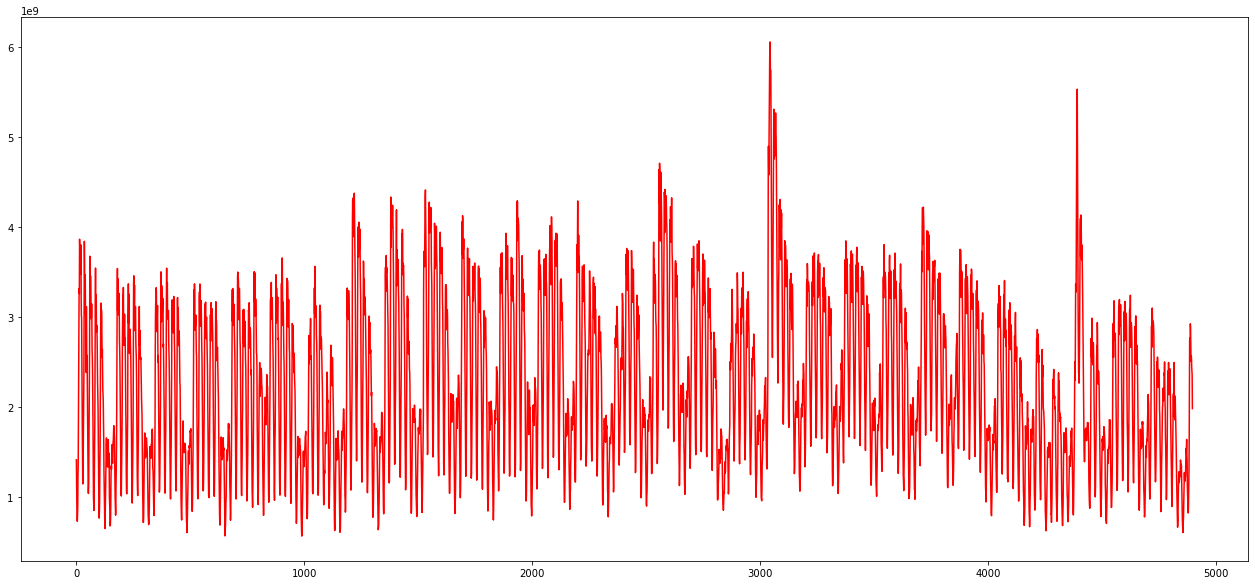

In [21]:
ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()

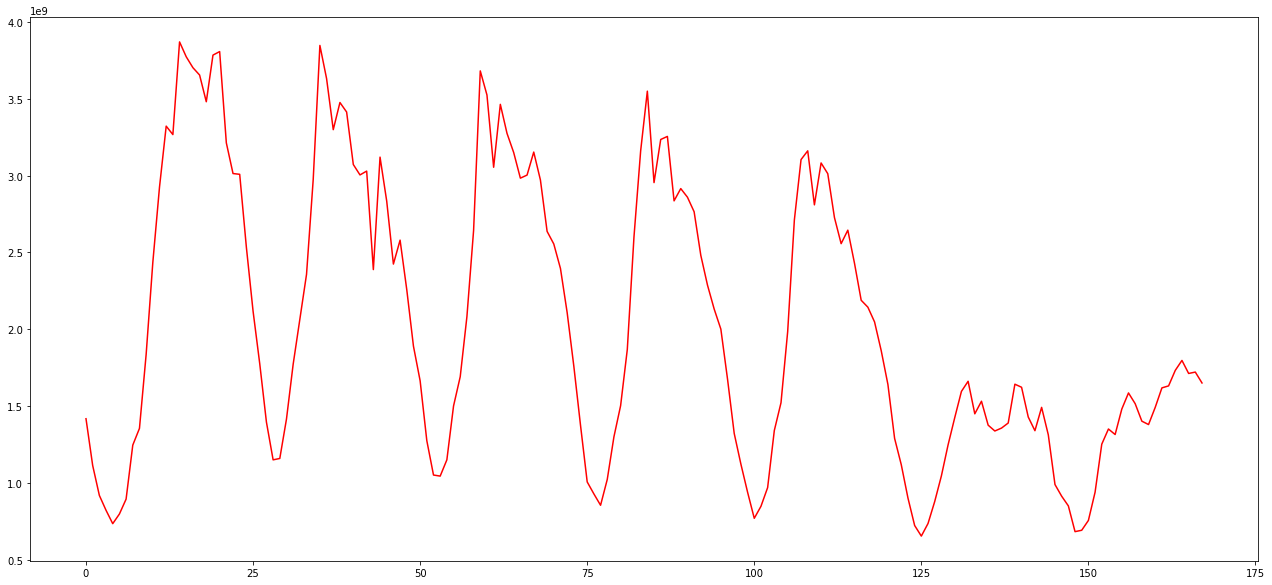

In [22]:
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

In [36]:
def prepare_data(seq, num):
    x = []
    y = []
    for i in range(0, (len(seq)- num), 1):
        input_ = seq[i:i+num]
        output = seq[i+num]
        
        x.append(input_)
        y.append(output)
    
    return np.array(x), np.array(y)

In [37]:
num = 168
x,y = prepare_data(sessions, num)
print(len(x))

4728


In [53]:
ind = int(0.9*len(x))

# prepare training and test data
X_train = x[:ind]
y_train = y[:ind]

X_test = x[ind:]
y_test = y[ind:]

In [54]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.fit_transform(X_test)

In [55]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [56]:
y_scaler=StandardScaler()
y_train = y_scaler.fit_transform(y_train)[:,0]
y_test = y_scaler.transform(y_test)[:,0]

In [57]:
X_train= X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test= X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)

(4255, 168, 1)


In [58]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras

In [59]:
model = Sequential()
model.add(LSTM(128, input_shape = (168,1)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'linear'))

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(loss='mse',optimizer='adam')
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss',
        verbose=1, save_best_only=True, mode='min')
history=model.fit(X_train, y_train ,epochs=30, batch_size=32, 
           validation_data=(X_test,y_test), callbacks=[mc])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1627
Epoch 1: val_loss improved from inf to 0.41546, saving model to best_model.hdf5
133/133 [==============================] - 21s 142ms/step - loss: 0.1627 - val_loss: 0.4155
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0426
Epoch 2: val_loss improved from 0.41546 to 0.35981, saving model to best_model.hdf5
133/133 [==============================] - 18s 132ms/step - loss: 0.0426 - val_loss: 0.3598
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0392
Epoch 3: val_loss improved from 0.35981 to 0.35271, saving model to best_model.hdf5
133/133 [==============================] - 17s 128ms/step - loss: 0.0392 - val_loss: 0.3527
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0334
Epoch 4: val_loss improved from 0.35271 to 0.33747, saving model to best_model.hdf5
133/133 [==============================] - 18s 133ms/step - loss: 0.0334 - val_loss:

In [63]:
model.load_weights('best_model.hdf5')

In [65]:
mse = model.evaluate(X_test,y_test)
print("Mean Square Error:",mse)

15/15 [==============================] - 1s 71ms/step - loss: 0.3073
Mean Square Error: 0.30727091431617737


In [66]:
def compute_moving_average(data):
    pred=[]
    for i in data:
        avg=np.sum(i)/len(i)
        pred.append(avg)
    return np.array(pred)

In [68]:
x_reshaped = X_test.reshape(-1,168)

In [69]:
y_pred = compute_moving_average(x_reshaped)

In [70]:
mse = np.sum ( (y_test - y_pred) **2 ) / (len(y_test))
print("Mean square of error:- ",mse)

Mean square of error:-  0.7844966475111791


In [82]:
def forecast(X_test, no_of_pred, ind):
    predictions=[]
    temp = X_test[ind]
    
    for i in range(no_of_pred):
        pred=model.predict(temp.reshape(1,-1,1))[0][0]
        temp = np.insert(temp,len(temp),pred)
        predictions.append(pred)
        temp = temp[1:]
    return predictions

In [85]:
no_of_pred =24
ind=72
y_pred= forecast(X_test,no_of_pred,ind)
y_true = y_test[ind:ind+(no_of_pred)]
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

In [86]:
def plot(y_true,y_pred):
    ar = np.arange(len(y_true))
    plt.figure(figsize=(22,10))
    plt.plot(ar, y_true,'r')
    plt.plot(ar, y_pred,'y')
    plt.show()

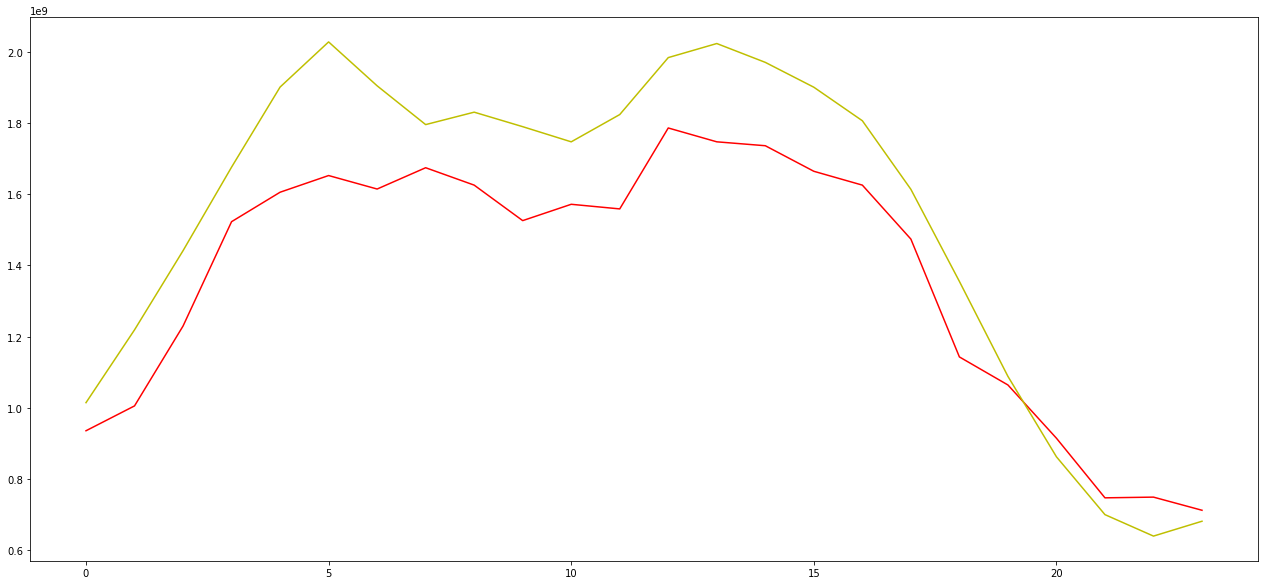

In [87]:
plot(y_true,y_pred)

# Conclusion

The CNN based model still has the advantage of speed. Now, this is not the end of the row. We can further improve this model by taking measures like, we can make the time series data stationary and then use it for making sequences and then later use it in the model input sequences.